In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx
import warnings
from itertools import permutations

#from mlxtend.frequent_patterns import apriori
#from mlxtend.frequent_patterns import association_rules

In [12]:
sns.set(style="darkgrid", color_codes=True)
pd.set_option('display.max_columns', 75)

## Dataset

In [13]:
data_df = pd.read_csv('../datasets/market_basket/market_basket.csv', header=None)
data_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil
1,burgers,meatballs,eggs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chutney,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,turkey,avocado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,mineral water,milk,energy bar,whole wheat rice,green tea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7501 entries, 0 to 7500
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       7501 non-null   object
 1   1       5747 non-null   object
 2   2       4389 non-null   object
 3   3       3345 non-null   object
 4   4       2529 non-null   object
 5   5       1864 non-null   object
 6   6       1369 non-null   object
 7   7       981 non-null    object
 8   8       654 non-null    object
 9   9       395 non-null    object
 10  10      256 non-null    object
 11  11      154 non-null    object
 12  12      87 non-null     object
 13  13      47 non-null     object
 14  14      25 non-null     object
 15  15      8 non-null      object
 16  16      4 non-null      object
 17  17      4 non-null      object
 18  18      3 non-null      object
 19  19      1 non-null      object
dtypes: object(20)
memory usage: 1.1+ MB


In [15]:
data_df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
count,7501,5747,4389,3345,2529,1864,1369,981,654,395,256,154,87,47,25,8,4,4,3,1
unique,115,117,115,114,110,106,102,98,88,80,66,50,43,28,19,8,3,3,3,1
top,mineral water,mineral water,mineral water,mineral water,green tea,french fries,green tea,green tea,green tea,green tea,low fat yogurt,green tea,green tea,green tea,magazines,salmon,frozen smoothie,protein bar,spinach,olive oil
freq,577,484,375,201,153,107,96,67,57,31,22,15,8,4,3,1,2,2,1,1


In [16]:
class MostPopularItemsPlot:
    
    def __init__(self, item_count):
        
        self.item_count = item_count
        self.bins = np.linspace(0, 1, item_count)
        self.colors = plt.cm.rainbow(self.bins)
    
    def draw(self, data):
        frequencies = data.value_counts().head(self.item_count)
        frequencies.plot.bar(color=self.colors, figsize=(13, 5))

        plt.title('Frequency of the most popular items', fontsize=20)
        plt.xticks(rotation = 90)
        plt.grid()
        plt.show()
        
class TopChoicesPlot:
    
    def __init__(self, item_count, source_label):
        
        self.item_count = item_count
        self.source_label = source_label
        self.bins = np.linspace(0, item_count, 1)
        self.colors = plt.cm.Set1(self.bins)

        warnings.filterwarnings('ignore')
        
    def draw(self, df, target):
        
        df[self.source_label] = self.source_label
        df_truncated = data_df.truncate(before = -1, after = self.item_count)
        
        graph = nx.from_pandas_edgelist(df_truncated, source = self.source_label, target=target, edge_attr = True)
        
        plt.rcParams['figure.figsize'] = (13, 13)
        pos = nx.spring_layout(graph)

        nx.draw_networkx_nodes(graph, pos, node_size=12000, node_color = self.colors)
        nx.draw_networkx_edges(graph, pos, width = 3, alpha = 0.6, edge_color='black')
        nx.draw_networkx_labels(graph, pos, font_size=15, font_family='sans-serif')

        plt.axis('off')
        plt.grid()
        plt.title(f'Top {self.item_count} first choices', fontsize = 20)
        plt.show()
        
        return graph

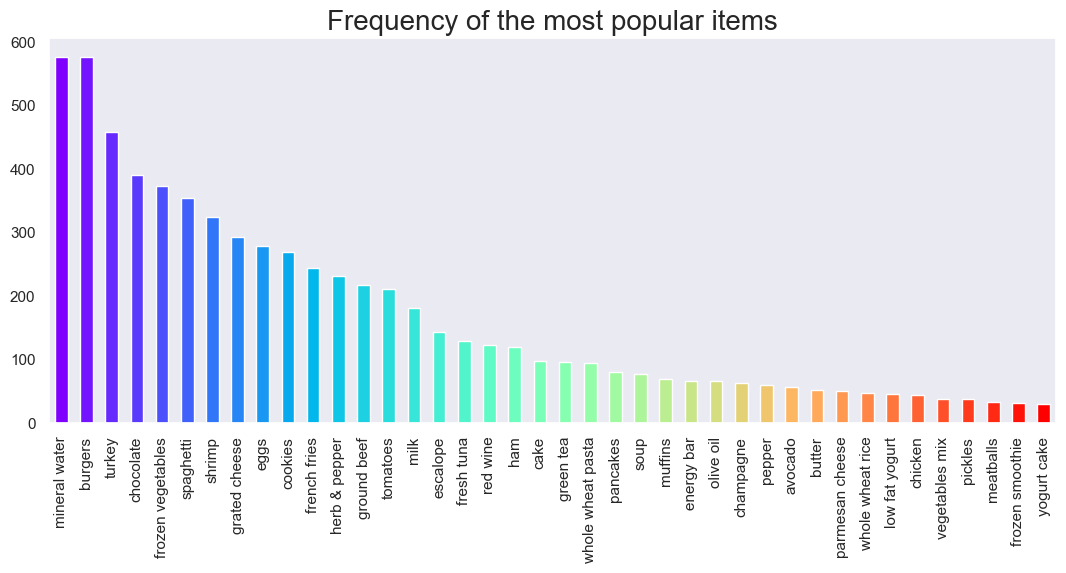

In [17]:
#Previewing most popular items frequencies for a specified column index
#Used for data analysis only. For example food items with bigger frequencies 
#should be correlated with more other items
preview_col = 0

mpi_plot = MostPopularItemsPlot(40)
mpi_plot.draw(data_df[preview_col])

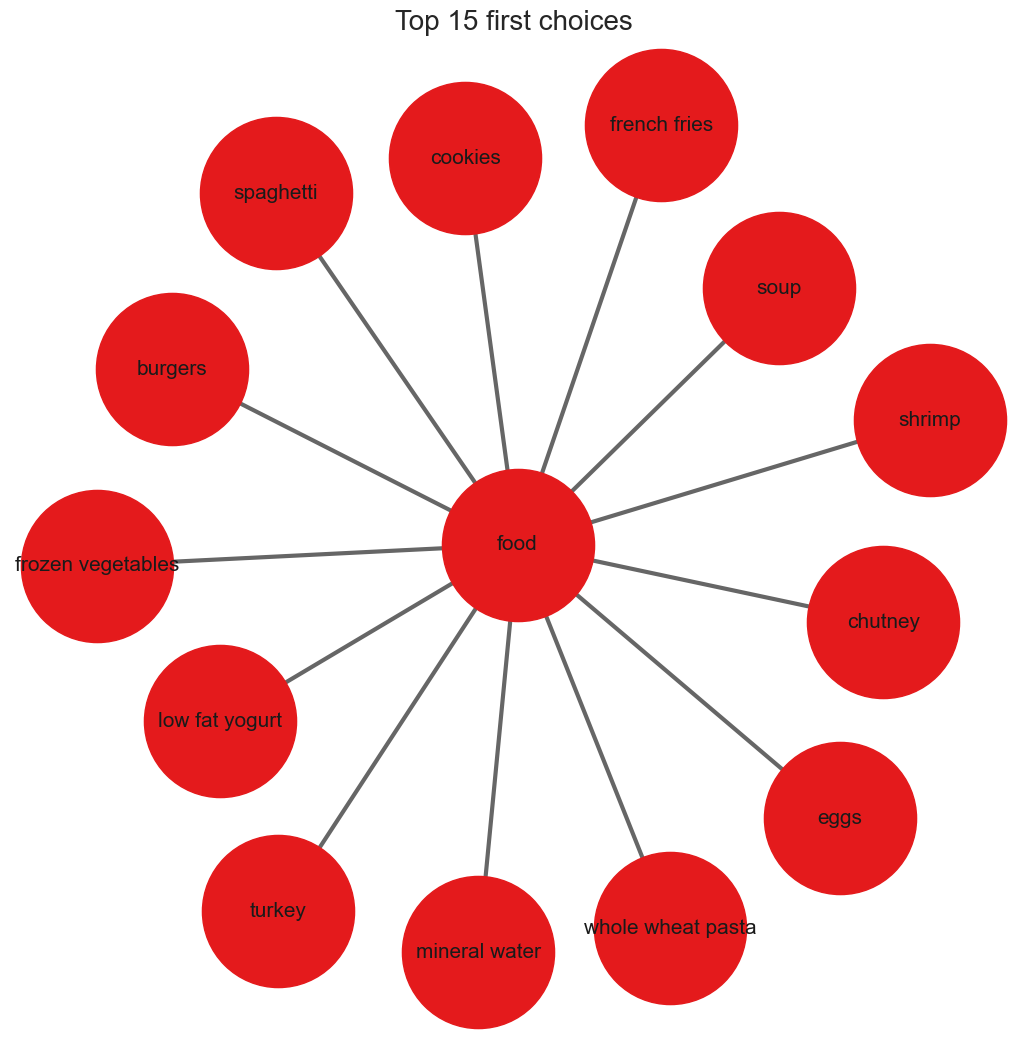

In [18]:
#Previewing top 15 choices for a specified column index
#Used for data analysis only. For example we can see how the number
#of food items descreses for the columns at a right table side
preview_col = 0

tc_plot = TopChoicesPlot(15, 'food')
graph = tc_plot.draw(data_df, preview_col)

## Getting the list of transactions

In [46]:
class Transaction(list):
    
    def __init__(self, values):
        super().__init__(self)
        self.extend(values)
    
    def from_df(df, row):
        values = [str(df.values[row, j]) for j in range(0, columns_len)]
        return Transaction(values)

class TransactionList(list):
    def __init__(self):
        super().__init__(self)
    
    def from_df(df):
        df_len = len(df)
        columns_len = len(df.columns)
    
        transactions = TransactionList()
        for i in range(0, df_len) :
            transactions.append(Transaction.from_df(df, i))
        
        return transactions
    
transactions = TransactionList.from_df(data_df)
transactions[:1]

[['shrimp',
  'almonds',
  'avocado',
  'vegetables mix',
  'green grapes',
  'whole weat flour',
  'yams',
  'cottage cheese',
  'energy drink',
  'tomato juice',
  'low fat yogurt',
  'green tea',
  'honey',
  'salad',
  'mineral water',
  'salmon',
  'antioxydant juice',
  'frozen smoothie',
  'spinach',
  'olive oil',
  'food']]